# CDL Cohort Project 2021: Week 1

In this notebook, we will summarise our work towards simulating a Google-like quantum supremacy experiment on
a trapped-ion quantum computer.

In [5]:
from src.simulation_utils import *
from src.plotting_utils import *

## Speckle Patterns

For our first task, we simulate random circuits.
These circuits consist of layers of random single-qubit gates and layers of random two-qubit MS gates.

1. Choose the number of qubits to simulate, and the depth of our random circuit:

In [6]:
n_qubits = 4         # Number of qubits
cct_depth = 1000     # Circuit depth

2. Initialize all qubits in the $| 0 \rangle$ state:

In [7]:
psi = tn.onedim.init_mps_allzero(n_qubits, 2)

3. Apply a random circuit:

In [8]:
psi = apply_random_circuit(psi, n_qubits, cct_depth)

4. Calculate the probabilities of measuring each output:

In [9]:
probs = output_probabilities(psi)

5. Plot the speckle pattern for our random circuit:

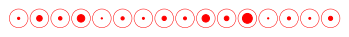

In [10]:
speckle_pattern(probs)